In [4]:
# Import necessary libraries
import cv2
import torch
import numpy as np
from torchvision import transforms
from PIL import Image
import os
import matplotlib.pyplot as plt

In [5]:
# Load the DeepLabV3 model for semantic segmentation
model = torch.hub.load('pytorch/vision:v0.6.0', 'deeplabv3_resnet101', pretrained=True)
model.eval()

Downloading: "https://github.com/pytorch/vision/zipball/v0.6.0" to C:\Users\HP/.cache\torch\hub\v0.6.0.zip
C:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/deeplabv3_resnet101_coco-586e9e4e.pth" to C:\Users\HP/.cache\torch\hub\checkpoints\deeplabv3_resnet101_coco-586e9e4e.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

In [6]:
# Function to make the foreground transparent based on a mask
def make_transparent_foreground(pic, mask):
    """
    Create a transparent foreground image based on a binary mask.

    Args:
        pic (PIL.Image): Input image.
        mask (numpy.ndarray): Binary mask.

    Returns:
        numpy.ndarray: Transparent foreground image.
    """
    # split the image into channels
    b, g, r = cv2.split(np.array(pic).astype('uint8'))
    # add an alpha channel with and fill all with transparent pixels (max 255)
    a = np.ones(mask.shape, dtype='uint8') * 255
    # merge the alpha channel back
    alpha_im = cv2.merge([b, g, r, a], 4)
    # create a transparent background
    bg = np.zeros(alpha_im.shape)
    # setup the new mask
    new_mask = np.stack([mask, mask, mask, mask], axis=2)
    # copy only the foreground color pixels from the original image where mask is set
    foreground = np.where(new_mask, alpha_im, bg).astype(np.uint8)

    return foreground

In [7]:
# Function to remove the background from an input image
def remove_background(input_image):
    """
    Remove the background from an input image using DeepLabV3 model.

    Args:
        input_image (PIL.Image): Input image.

    Returns:
        numpy.ndarray: Foreground image with transparent background.
        numpy.ndarray: Binary mask of the profile foreground.
    """
    preprocess = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    input_tensor = preprocess(input_image)
    input_batch = input_tensor.unsqueeze(0)  # create a mini-batch as expected by the model

    # move the input and model to GPU for speed if available
    if torch.cuda.is_available():
        input_batch = input_batch.to('cuda')
        model.to('cuda')

    with torch.no_grad():
        output = model(input_batch)['out'][0]
    output_predictions = output.argmax(0)

    # create a binary (black and white) mask of the profile foreground
    mask = output_predictions.byte().cpu().numpy()
    background = np.zeros(mask.shape)
    bin_mask = np.where(mask, 255, background).astype(np.uint8)

    foreground = make_transparent_foreground(input_image, bin_mask)

    return foreground, bin_mask

In [10]:
# Directory containing input images
input_directory = r"C:\Users\HP\Desktop\BG remover\test images"

# Get a list of image filenames in the input directory
image_filenames = [filename for filename in os.listdir(input_directory) if filename.endswith((".jpg", ".jpeg", ".png"))]

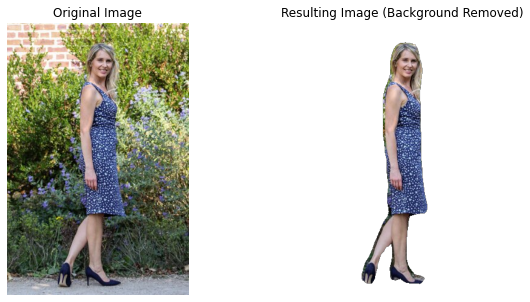

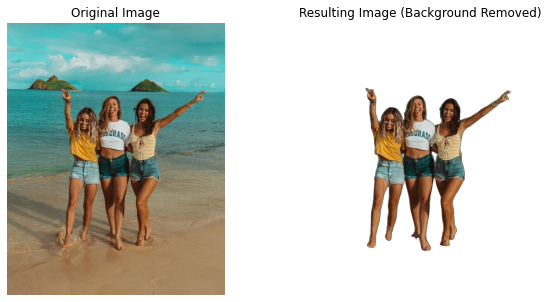

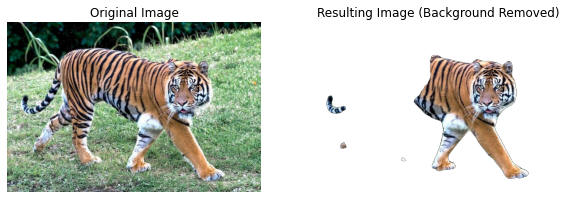

In [ ]:
# Loop through each image
for image_filename in image_filenames:
    # Construct the full path to the input image
    input_image_path = os.path.join(input_directory, image_filename)

    # Load and process the input image
    input_image = Image.open(input_image_path)
    output_foreground, _ = remove_background(input_image)

    # Plot the original and resulting images using Matplotlib
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(input_image)
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(output_foreground)
    plt.title("Resulting Image (Background Removed)")
    plt.axis("off")

    plt.show()
    print("\n","="*100)